In [ ]:
from dotenv import load_dotenv

load_dotenv()

# Nodes and edges

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

from IPython.display import Image

In [ ]:
def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

In [ ]:
graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)
graph.add_node("final_node", add_one)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())

In [ ]:
runnable.invoke("a")

## Conditional Edges

In [ ]:
def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("use_b")
    return input


def work_with_c(input: list[HumanMessage]):
    print("use_c")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "use_b"
    else:
        return "use_c"
    

graph = MessageGraph()

graph.add_node("entry", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "entry",
    router,
    {
        "use_b": "branch_b",
        "use_c": "branch_c"
    },
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("entry")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())



In [ ]:
runnable.invoke("Hello")

In [ ]:
runnable.invoke("use_b")

## Cycles

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

llm = ChatOpenAI()

In [ ]:
def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Action Taken: ", [msg.content for msg in input])

    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))

    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    else:
        return "action"
    

graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "__end__": END
    },
)
graph.add_edge("action", "agent")
graph.set_entry_point("agent")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())


In [ ]:
runnable.invoke("Hello world")

## Real Agent

In [ ]:
import operator
import random
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph

llm = ChatOpenAI()

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [ ]:
@tool
def fake_weather_api(city: str) -> str:
    """Returns the weather for a given city."""
    if random.randint(0, 3) == 0:
        return f"Sunny, {random.randint(10, 30)} degrees"
    else:
        return "Service unavailable"

In [ ]:
llm_with_tools = llm.bind_tools([fake_weather_api])

tool_mapping = {
    "fake_weather_api": fake_weather_api,
}

messages = [HumanMessage("How will the weather be in Copenhagen today? I would like to eat outside if possible")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)


for tool_call in llm_output.tool_calls:
    tool_name = tool_call["name"].lower()
    tool = tool_mapping[tool_name]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

In [ ]:
def should_continue(state: AgentState):
    print("--> should_continue")
    messages = state["messages"]
    last_message = messages[-1]

    print(f"State: {state}")
    print(f"Last message: {last_message}")
    print(f"Tool calls: {last_message.tool_calls}")

    if not last_message.tool_calls:
        print("---> Going to end")
        return "end"
    else:
        print("---> Going to continue")
        return "continue"
    

def call_model(state: AgentState):
    print("--> call_model")
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)

    print("Response: ", response)


    return {
        "messages": [response],
        "api_call_count": state["api_call_count"],
    }


def call_tool(state: AgentState):
    print("--> call_tool")
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool_name = tool_call["name"].lower()
    tool = tool_mapping[tool_name]
    tool_output = tool.invoke(tool_call["args"])

    state["api_call_count"] += 1
    print("Tool output: ", tool_output)
    print("API call count after this tool call: ", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {
        "messages": [tool_message],
        "api_call_count": state["api_call_count"],
    }


from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)


workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()
Image(app.get_graph().draw_mermaid_png())



In [ ]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")
human_message = HumanMessage(content="How will the weather be in Copenhagen today?")
messages = [system_message, human_message]

r = app.invoke({"messages": messages, "api_call_count": 0})




# LangGraph vs LCEL

In [1]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings



### With LCEL

In [ ]:

embedding_function = OpenAIEmbeddings()

In [2]:
docs = [
    Document(page_content="Raistlin is a mage", metadata={"source": "Dragonlance"}),
    Document(page_content="Tanis is a ranger", metadata={"source": "Dragonlance"}),
]


db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 2})

In [3]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

In [5]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI()

retrieval_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [6]:
retrieval_chain.invoke("What type is Tanis?")

'Tanis is a ranger.'

### With LangGraph

In [11]:
from typing import TypedDict
from langchain_core.messages import BaseMessage


chain_with_prompt = prompt | llm | StrOutputParser()

In [10]:
class AgentState(TypedDict):
    question: str
    raw_docs: list[BaseMessage]
    formatted_docs: list[str]
    generation: str



In [12]:
def get_docs(state: AgentState):
    print("Getting documents...", state)
    question = state["question"]
    docs = retriever.invoke(question)
    state["raw_docs"] = docs
    return state


def format_docs(state: AgentState):
    print("Formatting documents...", state)
    documents = state["raw_docs"]
    state["formatted_docs"] = "\n\n".join([doc.page_content for doc in documents])
    return state


def generate(state: AgentState):
    print("Generating response...", state)
    question = state["question"]
    formatted_docs = state["formatted_docs"]
    result = chain_with_prompt.invoke({"question": question, "context": formatted_docs})
    state["generation"] = result
    return state
    

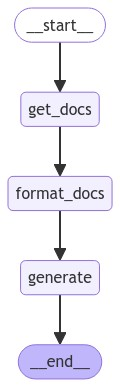

In [13]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

workflow = StateGraph(AgentState)

workflow.add_node("get_docs", get_docs)
workflow.add_node("format_docs", format_docs)
workflow.add_node("generate", generate)

workflow.add_edge("get_docs", "format_docs")
workflow.add_edge("format_docs", "generate")
workflow.add_edge("generate", END)

workflow.set_entry_point("get_docs")

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
app.invoke({"question": "What type is Tanis?"})

Getting documents... {'question': 'What type is Tanis?', 'raw_docs': None, 'formatted_docs': None, 'generation': None}
Formatting documents... {'question': 'What type is Tanis?', 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'), Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')], 'formatted_docs': None, 'generation': None}
Generating response... {'question': 'What type is Tanis?', 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'), Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')], 'formatted_docs': 'Tanis is a ranger\n\nRaistlin is a mage', 'generation': None}


{'question': 'What type is Tanis?',
 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'),
  Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')],
 'formatted_docs': 'Tanis is a ranger\n\nRaistlin is a mage',
 'generation': 'Tanis is a ranger.'}